In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

%config InlineBackend.figure_format = 'retina'

torch.__version__

'2.2.0'

In [2]:
g = nx.Graph()
edges_with_atts = [(1, 2, {'length':5}),
                (1, 3, {'length':11}),
                (2, 4, {'length':4}),
                (2, 5,{'length':7})]
g.add_edges_from(edges_with_atts)

lengths = nx.all_pairs_dijkstra_path(g, weight='length', cutoff=8)
dict(map(lambda x: (x[0], set(x[1].keys()) - {x[0]}), lengths))

{1: {2}, 2: {1, 4, 5}, 3: set(), 4: {2}, 5: {2}}

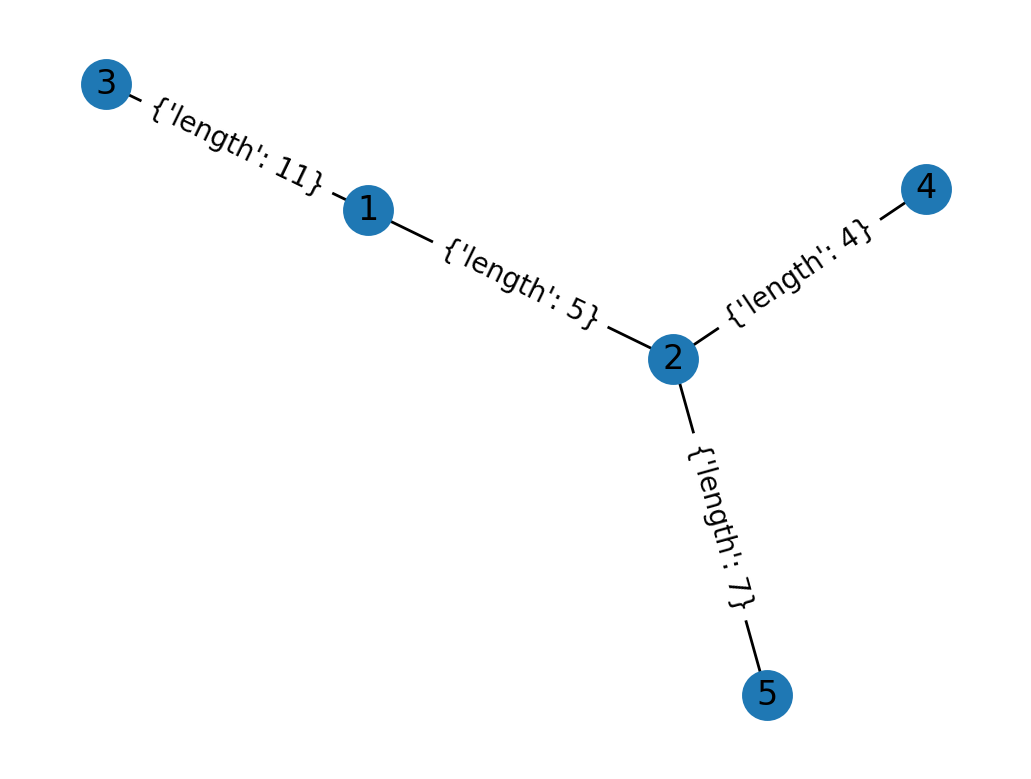

In [3]:
layout = nx.spring_layout(g)
nx.draw_networkx(g, pos=layout)
nx.draw_networkx_edge_labels(g, pos=layout)
plt.axis('off')
plt.show()

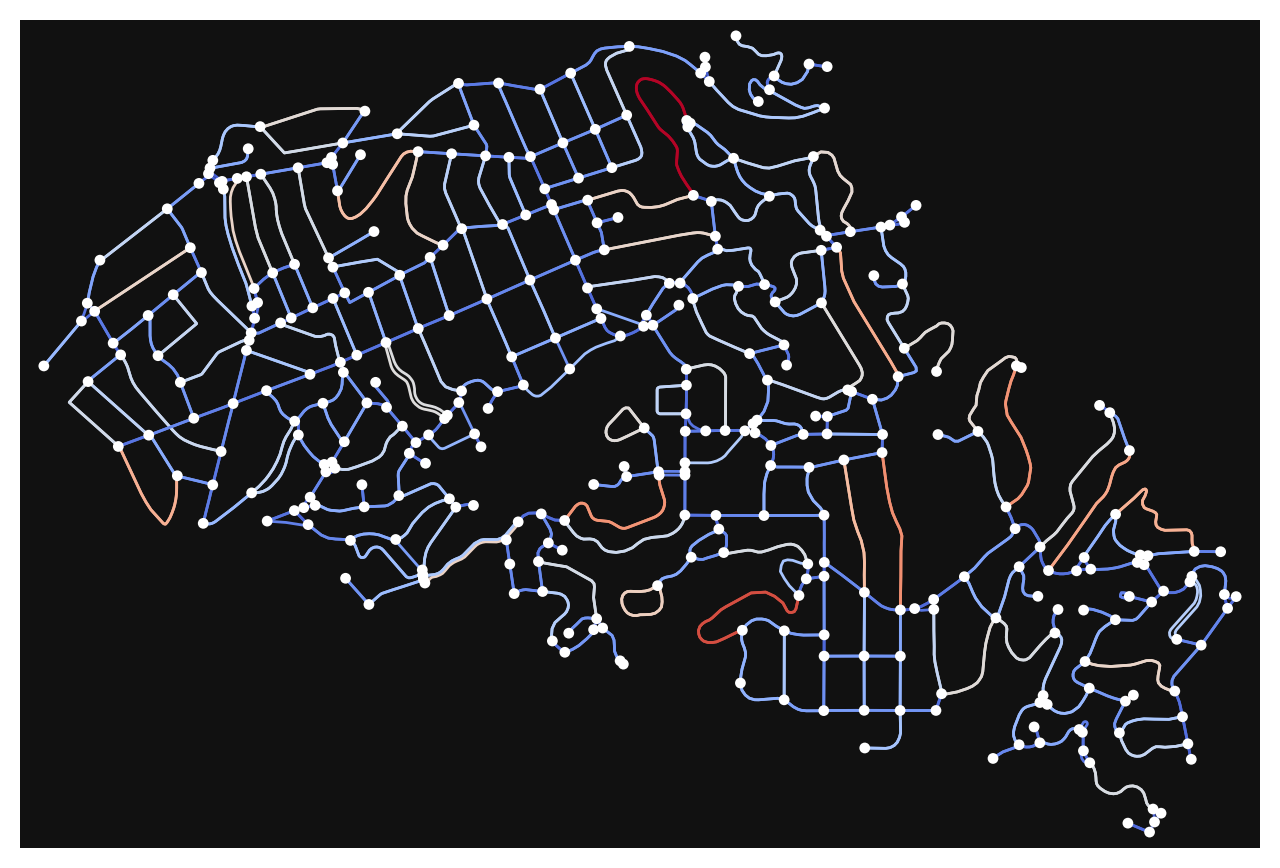

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
import osmnx as ox

G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
ec = ox.plot.get_edge_colors_by_attr(G, attr='travel_time', cmap='coolwarm')
ox.plot_graph(G, edge_color=ec)

In [13]:
def get_driveshed_size(G, time=30):
    drivesheds = nx.all_pairs_dijkstra_path(G, weight='travel_time', cutoff=time)
    reachable_nodes = dict(map(lambda x: (x[0], set(x[1].keys()) - {x[0]}), drivesheds))
    G = G.copy()
    nx.set_node_attributes(G, reachable_nodes, 'reachable_nodes')
    return G

In [14]:
G = get_driveshed_size(G, time=30)

In [15]:
%timeit get_driveshed_size(G)

6.04 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
list(nx.get_node_attributes(G, "reachable_nodes").items())[0]

(53017091, {53018397, 53075599, 53097976, 53097980})

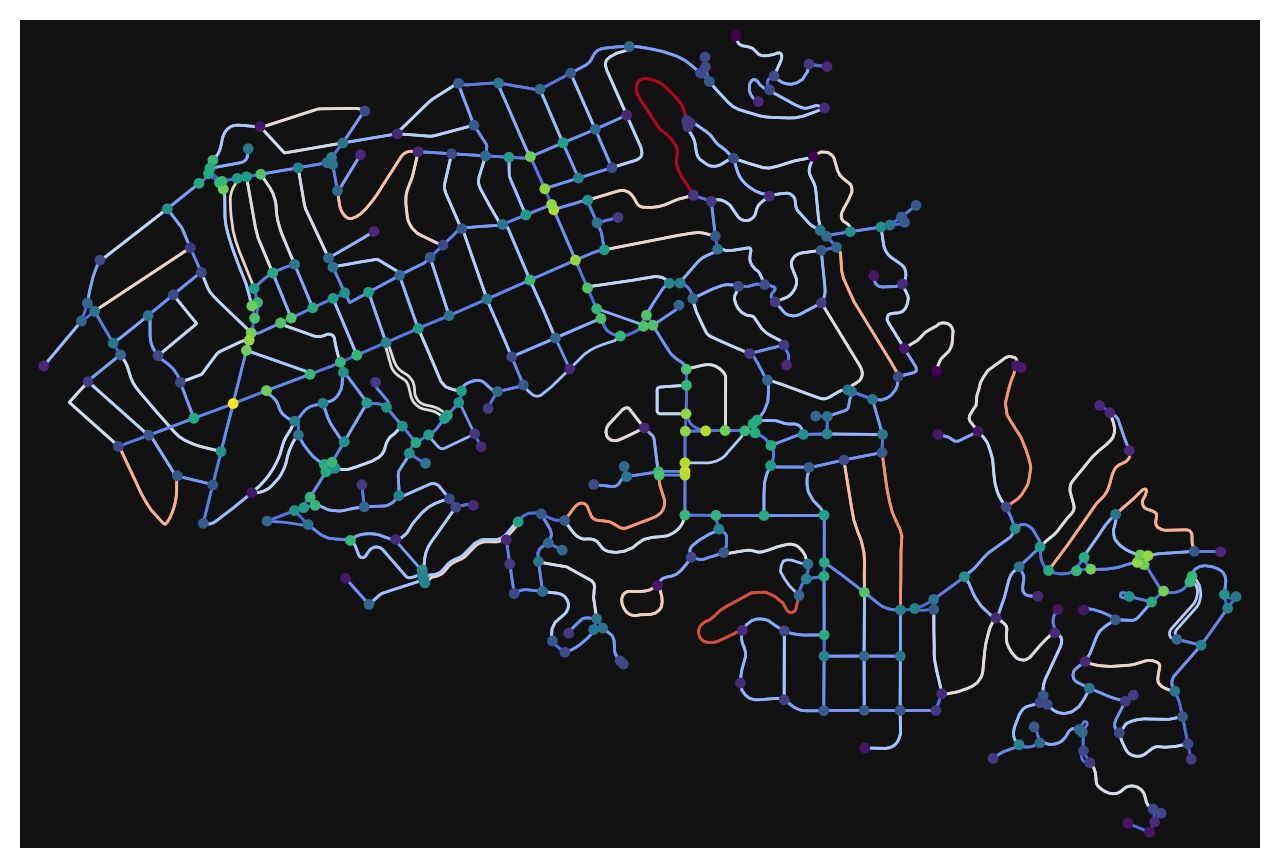

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
G = get_driveshed_size(G)
num_reachable_nodes = dict(map(lambda x: (x[0], len(x[1])), nx.get_node_attributes(G, "reachable_nodes").items()))
nx.set_node_attributes(G, num_reachable_nodes, 'num_reachable_nodes')
nd = ox.plot.get_node_colors_by_attr(G, attr='num_reachable_nodes', cmap='viridis')
ox.plot_graph(G, node_color=nd, edge_color=ec)

## Benchmarking

In [18]:
print(f"Number of nodes: {G.number_of_nodes()}")

Number of nodes: 353


### Drive time scaling

In [20]:
from timeit import repeat

runtimes = []
for cutoff in range(10, 60, 5):
    runtime = min(repeat(f'get_driveshed_size(G, time={cutoff})', globals=globals(), repeat=100, number=100)) / 100
    print(f"Runtime for cutoff {cutoff}: {runtime*1000:.2f} ms")
    runtimes.append(runtime)

Runtime for cutoff 10: 3.13 ms
Runtime for cutoff 15: 3.64 ms
Runtime for cutoff 20: 4.30 ms
Runtime for cutoff 25: 5.08 ms
Runtime for cutoff 30: 6.02 ms
Runtime for cutoff 35: 7.11 ms
Runtime for cutoff 40: 9.16 ms
Runtime for cutoff 45: 10.63 ms
Runtime for cutoff 50: 11.67 ms
Runtime for cutoff 55: 13.31 ms


Text(0.5, 1.0, 'Runtime as function of drive time')

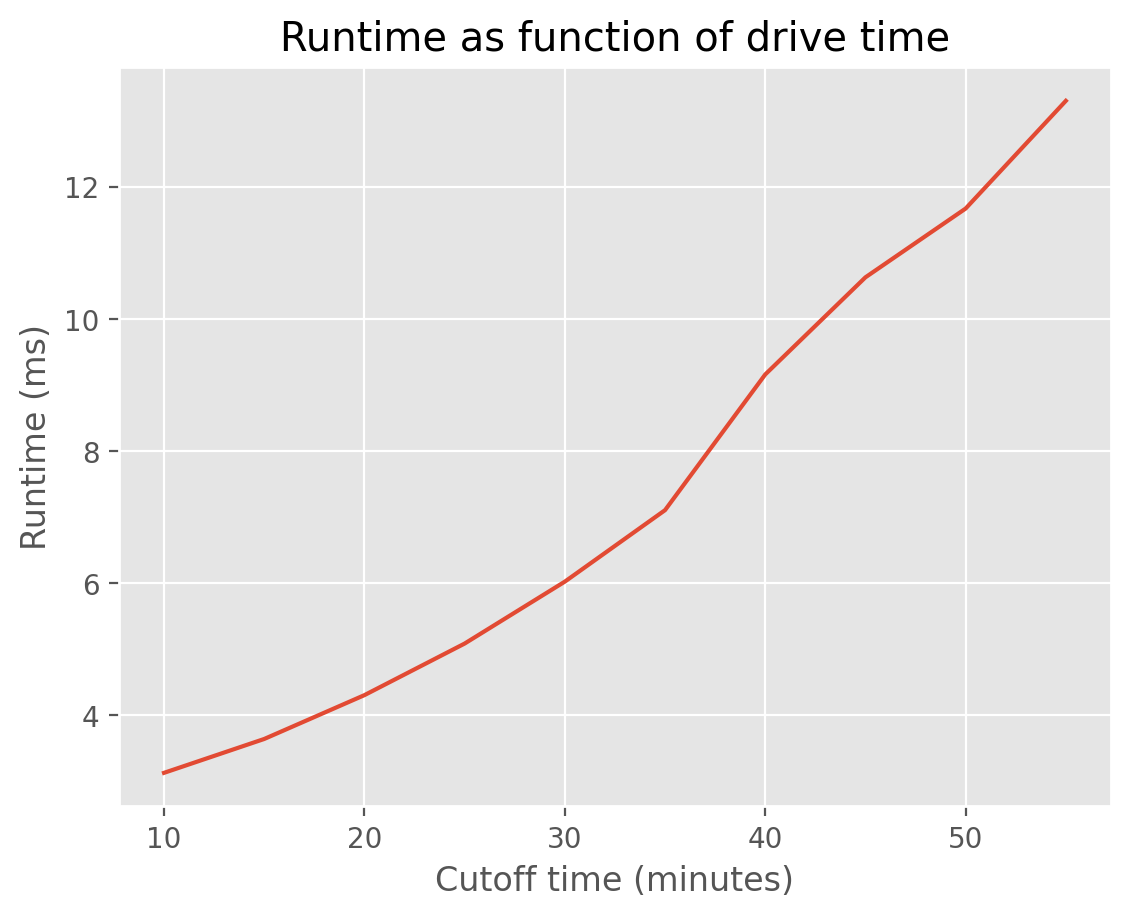

In [21]:
plt.style.use('ggplot')
plt.plot(list(range(10, 60, 5)), list(map(lambda x: x*1000, runtimes)))
plt.xlabel('Cutoff time (minutes)')
plt.ylabel('Runtime (ms)')
plt.title('Runtime as function of drive time')

### Node scaling

We expect this to be linear as the implementation of `all_pairs_dijkstra_path` is just:

```python
path = single_source_dijkstra_path
# TODO This can be trivially parallelized.
for n in G:
    yield (n, path(G, n, cutoff=cutoff, weight=weight))
```
Source: https://networkx.org/documentation/stable/_modules/networkx/algorithms/shortest_paths/weighted.html#all_pairs_dijkstra_path

In [22]:
from random import choice
# pick random node from G
def pick_random_subset_of_graph(G, limit=100, verbose=False):
    node = choice(list(G.nodes()))
    if verbose:
        print(f"Source node: {node}")
    time_to_each_node = nx.single_source_dijkstra_path_length(G, node, weight='travel_time')
    closest_nodes = list(map(lambda x: x[0], sorted(time_to_each_node.items(), key=lambda x: x[1])))[:limit]
    return G.subgraph(closest_nodes)

Source node: 53059173


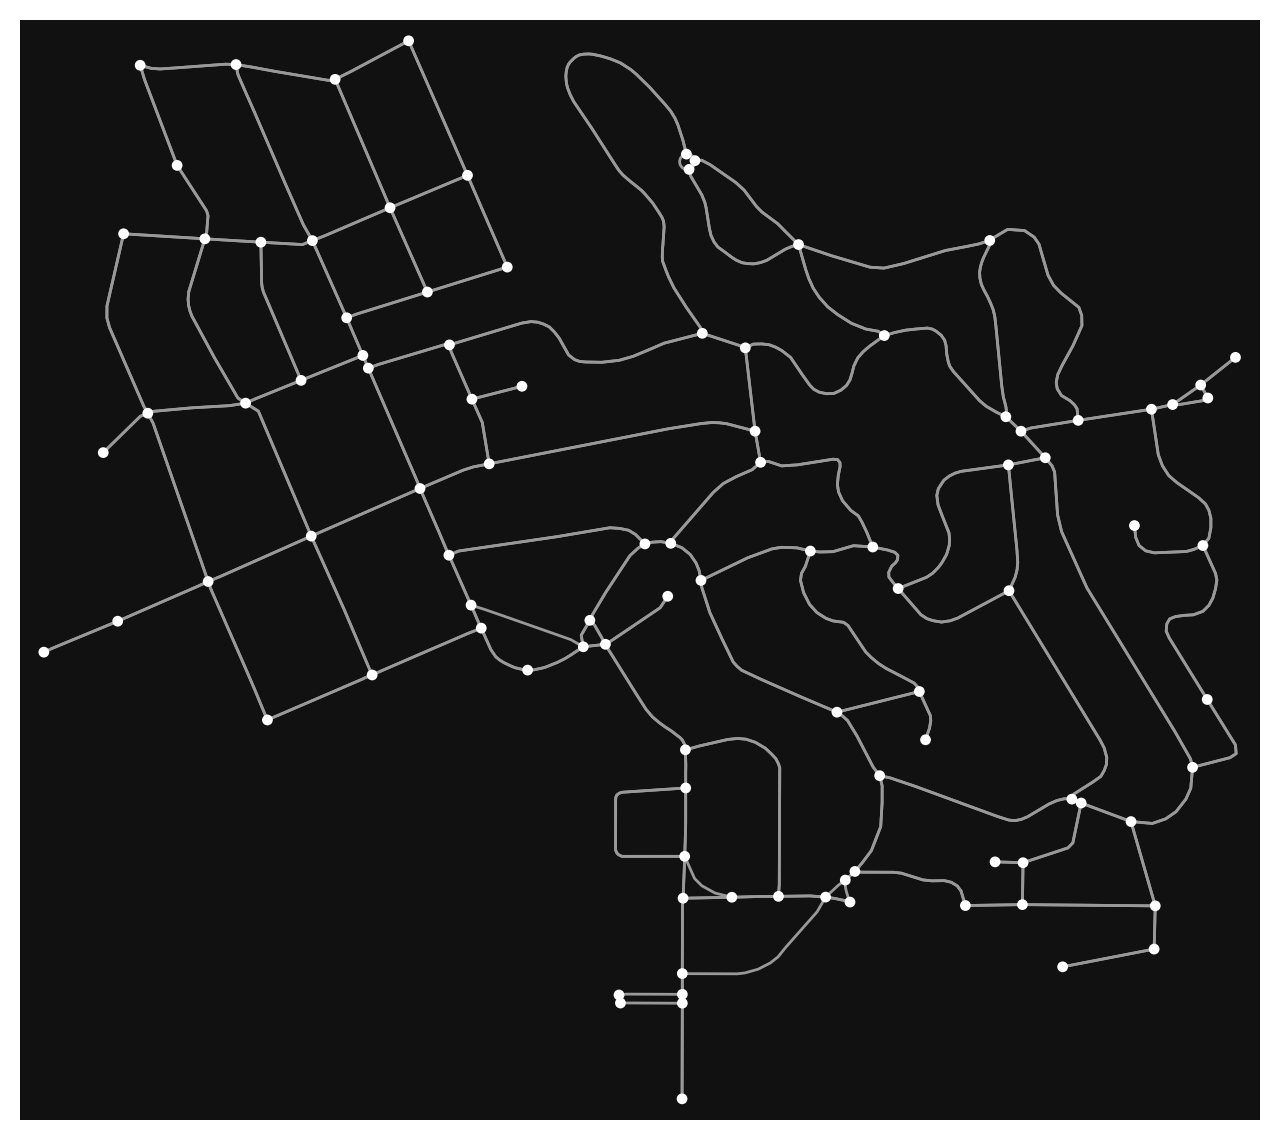

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
ox.plot_graph(pick_random_subset_of_graph(G, verbose=True))

In [27]:
def sample_subset_of_G_and_get_driveshed(G, subset_nodes, cutoff=30):
    G = pick_random_subset_of_graph(G, limit=subset_nodes)
    get_driveshed_size(G, time=cutoff)


node_runtimes = []
for subset_nodes in range(50, 350, 10):
    runtime = min(repeat(f'sample_subset_of_G_and_get_driveshed(G, subset_nodes={subset_nodes})', globals=globals(), repeat=50, number=50)) / 50
    print(f"Runtime for subset_nodes {subset_nodes}: {runtime*1000:.2f} ms")
    node_runtimes.append(runtime)

Runtime for subset_nodes 50: 3.87 ms
Runtime for subset_nodes 60: 4.55 ms
Runtime for subset_nodes 70: 5.46 ms
Runtime for subset_nodes 80: 6.01 ms
Runtime for subset_nodes 90: 6.99 ms
Runtime for subset_nodes 100: 7.61 ms
Runtime for subset_nodes 110: 8.25 ms
Runtime for subset_nodes 120: 9.29 ms
Runtime for subset_nodes 130: 9.87 ms
Runtime for subset_nodes 140: 10.74 ms
Runtime for subset_nodes 150: 11.36 ms
Runtime for subset_nodes 160: 11.49 ms
Runtime for subset_nodes 170: 12.76 ms
Runtime for subset_nodes 180: 13.45 ms
Runtime for subset_nodes 190: 14.56 ms
Runtime for subset_nodes 200: 14.94 ms
Runtime for subset_nodes 210: 15.85 ms
Runtime for subset_nodes 220: 16.79 ms
Runtime for subset_nodes 230: 16.59 ms
Runtime for subset_nodes 240: 18.15 ms
Runtime for subset_nodes 250: 18.98 ms
Runtime for subset_nodes 260: 19.37 ms
Runtime for subset_nodes 270: 20.09 ms
Runtime for subset_nodes 280: 20.84 ms
Runtime for subset_nodes 290: 21.76 ms
Runtime for subset_nodes 300: 22.93 ms


Text(0.5, 1.0, 'Runtime as function of number of nodes')

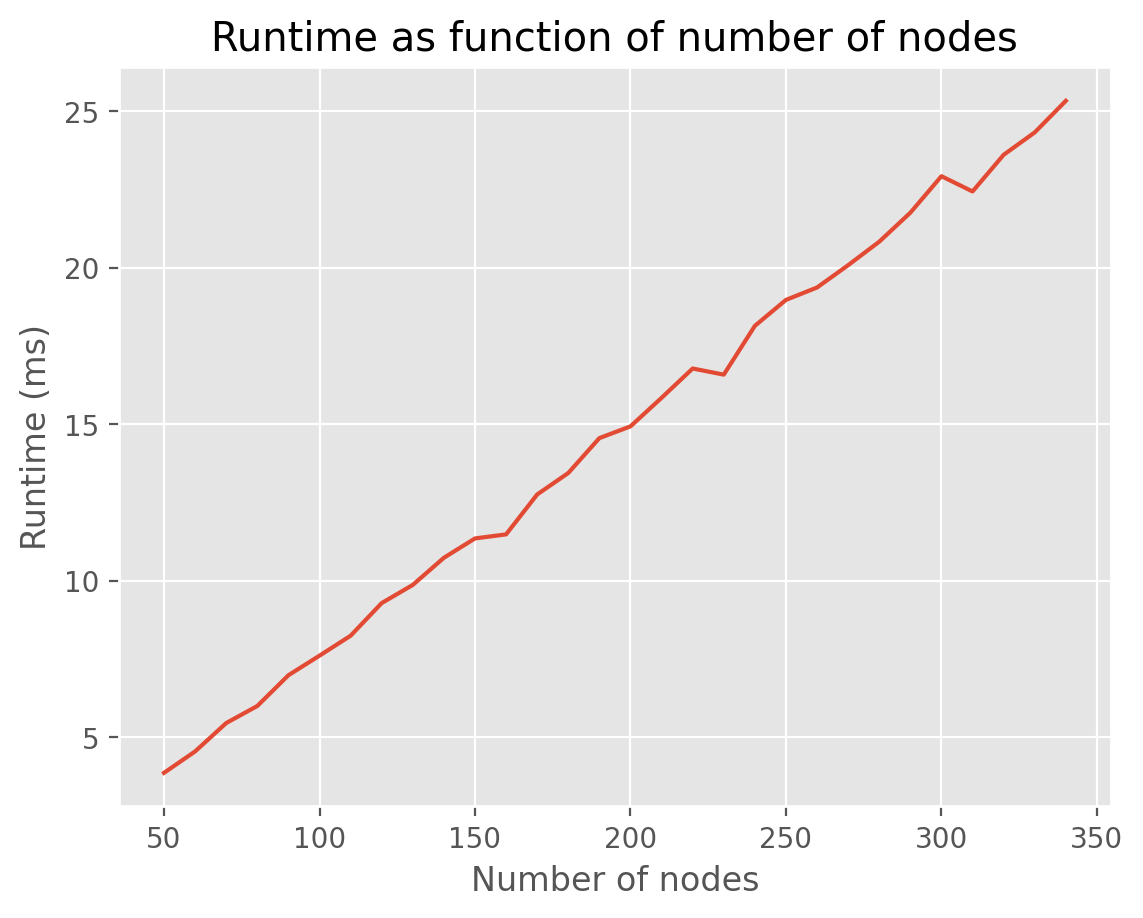

In [29]:
plt.plot(list(range(50, 350, 10)), list(map(lambda x: x*1000, node_runtimes)))
plt.xlabel('Number of nodes')
plt.ylabel('Runtime (ms)')
plt.title('Runtime as function of number of nodes')